# **RandomForest on Text Readability**
This notebook contains the process in which we used random forest to classify Arabic text readability

It preprocess data, uses Arabert to feature extract, then trains the model, then evaluates it

**Note**: At the end it attepts to search grid the best parameters but then those parameters were plugged in the model and retrained and reevaluated


In [2]:
# This is needed to get AraBERT (transformers) and its backend (torch)
!pip install transformers torch


In [10]:
# Imports
import pandas as pd
import numpy as np
import re
import time
import nltk
from nltk.tokenize import word_tokenize
import joblib
import torch
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [12]:
# Preprocessing
ARABIC_DIACRITICS = re.compile(r'[\u064B-\u0652]')

def remove_diacritics(text):
    return ARABIC_DIACRITICS.sub('', text)

def remove_non_alpha(text):
    return re.sub(r'[^\w\s]', '', text)

def clean_text(text):
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = remove_diacritics(text)
    text = remove_non_alpha(text)
    return re.sub(r'\s+', ' ', text).strip()

def calculate_morph_complexity(tokens_col):
    if pd.isna(tokens_col) or not tokens_col:
        return 1.0
    original_words = tokens_col.split()
    total_morph_units = 0
    total_words = 0
    for word in original_words:
        morph_units = word.count('+') + 1
        total_morph_units += morph_units
        total_words += 1
    return total_morph_units / total_words if total_words > 0 else 1.0

# Data Loading and Cleaning
FILEPATH = 'bayyin_dataset.csv'
df = pd.read_csv(FILEPATH)
df.dropna(subset=['Sentence', 'Readability_Level'], inplace=True)
target_le = LabelEncoder()
df['Readability_Level_Encoded'] = target_le.fit_transform(df['Readability_Level'])
print(f"Readability Levels Mapped to: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}\n")

# AraBERT is trained on real text, so we'll just remove diacritics
df['Clean_Sentence_for_BERT'] = df['Sentence'].apply(lambda x: remove_diacritics(str(x)))



Readability Levels Mapped to: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(6): np.int64(5)}



In [18]:

# Statistical Feature Engineering
print("\n--- Starting Statistical Feature Engineering ---")
df['Word_Count'] = df['Word_Count'].astype(int)
df['Clean_Lex'] = df['Lex'].apply(clean_text)
df['Avg_Lex_Length'] = df['Clean_Lex'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)
df['Lexical_Density'] = df['Clean_Lex'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0
)
df['Morph_Complexity'] = df['D3Tok'].apply(calculate_morph_complexity)
print("Statistical features calculated.")

# statistical feature matrix
X_stats_numeric = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values.astype(np.float64)




--- Starting Statistical Feature Engineering ---
Statistical features calculated.


In [31]:
# AraBERT Feature Extraction

print("\n--- Starting AraBERT Feature Extraction ---")

# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load AraBERT tokenizer and model
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device) # Move model to GPU
model.eval() # Set model to evaluation mode (disables dropout) --> maybe change later?

# tokenize all sentences
print("Tokenizing sentences...")
sentences = df['Clean_Sentence_for_BERT'].tolist()
print("Sentences number ", len(sentences))

# This tokenizes all sentences and prepares them for the model
tokenized_inputs = tokenizer(
    sentences,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt" # Return PyTorch tensors
)

# Create DataLoader for batch processing to make things faster
batch_size = 32
dataset = TensorDataset(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])
sampler = SequentialSampler(dataset)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)

# Process in Batches
print(f"Extracting embeddings in batches of {batch_size}...")
all_embeddings = []

# Use torch.no_grad() to save memory and speed up
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Embedding Sentences"):
        # Move batch tensors to the correct device
        batch_input_ids, batch_attention_mask = [b.to(device) for b in batch]

        # Get model outputs
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        # Get the [CLS] token embedding (the embedding for the entire sentence)
        # We take the embedding of the first token (index 0), which is [CLS]
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeddings)

# Combine all batch embeddings
X_arabert = np.vstack(all_embeddings)
print(f"AraBERT embedding matrix shape: {X_arabert.shape}") # Should be (46410, 768)



--- Starting AraBERT Feature Extraction ---
Using device: cuda
Tokenizing sentences...
Sentences number  46410
Extracting embeddings in batches of 32...


Embedding Sentences: 100%|██████████| 1451/1451 [11:42<00:00,  2.07it/s]


AraBERT embedding matrix shape: (46410, 768)


In [32]:

# Combine Features for Final Model
print("\n--- Combining Statistical and AraBERT Features ---")

# X_stats_numeric shape: (46410, 4)
# X_arabert shape: (46410, 768)

X_combined = np.hstack([X_stats_numeric, X_arabert])
y = df['Readability_Level_Encoded'].values

print(f"Final combined feature matrix shape: {X_combined.shape}")
print(f"Target vector shape: {y.shape}")



--- Combining Statistical and AraBERT Features ---
Final combined feature matrix shape: (46410, 772)
Target vector shape: (46410,)


***Split and save the training-test split***

In [33]:
# Split the new combined dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (37128, 772), Test set: (9282, 772)


In [34]:
# Convert to DataFrame if they’re numpy arrays
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train, columns=['Readability_Level'])
y_test_df = pd.DataFrame(y_test, columns=['Readability_Level'])

# Save to CSV
X_train_df.to_csv("X_train.csv", index=False)
X_test_df.to_csv("X_test.csv", index=False)
y_train_df.to_csv("y_train.csv", index=False)
y_test_df.to_csv("y_test.csv", index=False)

In [35]:
joblib.dump((X_train, X_test, y_train, y_test), "train_test_split.pkl")

print("✅ Train/test split saved to 'train_test_split.pkl'")
#X_train, X_test, y_train, y_test = joblib.load("train_test_split.pkl")

✅ Train/test split saved to 'train_test_split.pkl'


***Train dataset***

In [7]:

# Train Random Forest on Combined Features
print("\n--- Training Random Forest on Combined Features ---")
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_model.fit(X_train, y_train)
print(f"Model training finished in {time.time() - start_time:.2f} seconds.")



--- Training Random Forest on Combined Features ---
Model training finished in 620.06 seconds.


In [23]:
joblib.dump(rf_model, "rf_trained_model.pkl")

['rf_trained_model.pkl']

In [13]:

# Final Evaluation
print("\n--- Final Model Evaluation ---")
#interchangable with model
y_pred = rf_model.predict(X_test)

def accuracy_within_one(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    correct_within_1 = np.abs(y_true - y_pred) <= 1
    return correct_within_1.mean()

# Standard accuracy
acc = accuracy_score(y_test, y_pred)

# Classification report
report = classification_report(y_test, y_pred, target_names=[str(c) for c in target_le.classes_], digits=3)
# QWK
qwk_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')

# Accuracy ±1 level
acc_pm1 = accuracy_within_one(y_test, y_pred)

print("Standard Accuracy:", acc)
print("Accuracy ±1 level:", acc_pm1)
print("Quadratic Weighted Kappa (QWK):", qwk_score)
print("\nClassification Report:\n", report)



--- Final Model Evaluation ---
Standard Accuracy: 0.5449256625727213
Accuracy ±1 level: 0.8185735832794656
Quadratic Weighted Kappa (QWK): 0.7621672051277621

Classification Report:
               precision    recall  f1-score   support

           1      0.578     0.737     0.648      1547
           2      0.508     0.542     0.525      1547
           3      0.422     0.359     0.388      1547
           4      0.425     0.255     0.319      1547
           5      0.530     0.610     0.567      1547
           6      0.727     0.766     0.746      1547

    accuracy                          0.545      9282
   macro avg      0.532     0.545     0.532      9282
weighted avg      0.532     0.545     0.532      9282



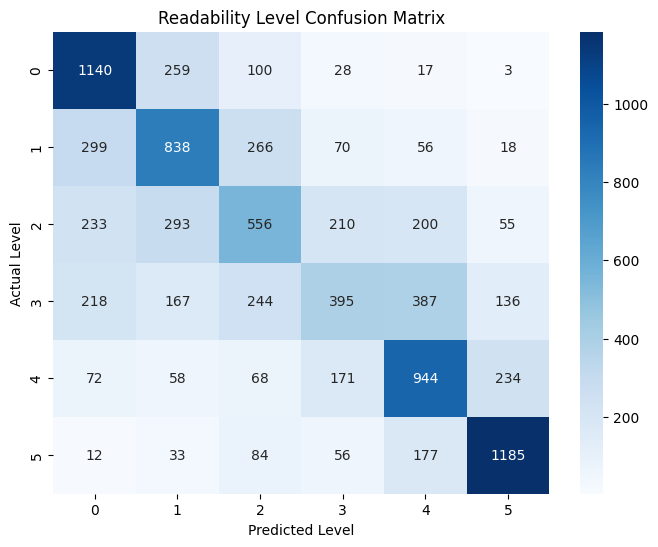

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Level")
plt.ylabel("Actual Level")
plt.title("Readability Level Confusion Matrix")
plt.show()

In [22]:

#  Feature Importance
print("\n--- Top Feature Importances ---")

# Create feature names for the combined matrix
stats_features = ['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']
arabert_features = [f'BERT_{i}' for i in range(X_test.shape[1]-4)]
all_feature_names = stats_features + arabert_features

importances = rf_model.feature_importances_

importance_df = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

print("Top 20 most important features:")
print(importance_df.head(20))

print("\nImportance of Statistical Features:")
print(importance_df.loc[stats_features])



--- Top Feature Importances ---
Top 20 most important features:
Word_Count         0.017470
BERT_47            0.011251
BERT_142           0.007516
Lexical_Density    0.006302
BERT_257           0.005811
BERT_290           0.005349
BERT_444           0.005314
BERT_92            0.005123
BERT_598           0.004835
BERT_485           0.004780
BERT_294           0.004574
BERT_279           0.004508
BERT_14            0.004196
BERT_373           0.003998
BERT_699           0.003782
BERT_538           0.003747
BERT_424           0.003627
BERT_306           0.003526
BERT_307           0.003442
BERT_23            0.003397
dtype: float64

Importance of Statistical Features:
Word_Count          0.017470
Avg_Lex_Length      0.001987
Lexical_Density     0.006302
Morph_Complexity    0.001214
dtype: float64


# Trying to Find Optimal parameters
Really useless choose everything to be the maximum

In [6]:
X_train, X_test, y_train, y_test = joblib.load("train_test_split.pkl")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (37128, 772), Test set: (9282, 772)


In [5]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 400],     # KEEP this in the grid
    'max_depth': [None, 15, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

halving = HalvingGridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    factor=3,
    resource='n_samples',       # vary training set size, not n_estimators
    max_resources=X_train.shape[0],  # number of training samples
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

halving.fit(X_train, y_train)

print("Best params:", halving.best_params_)
best = halving.best_estimator_
y_pred = best.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

joblib.dump(best, "rf_best_halving_nsamples.pkl")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 458
max_resources_: 37128
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 458
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 1
n_candidates: 36
n_resources: 1374
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 2
n_candidates: 12
n_resources: 4122
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 3
n_candidates: 4
n_resources: 12366
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 37098
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}
Test accuracy: 0.5449256625727213
              precision    recall  f1-score   support

           0       0.58      0.74      0.65      1547
           1       0.51      0.54      0.52      1547
           2       0.42      0.36      0.39      1547
           3       0.42      0.26      0.32      1547
           4       0.53      0.61      0.57      1547
           5       0.73      0.77      0.75      1547

    accuracy                           0.54      9282
   macro avg       0.53      0.54      0.53      9282
weighted avg       0.53      0.54      0.53      9282



['rf_best_halving_nsamples.pkl']